# Exercises 3.

*Antti Härkönen*

## 1.

$$ q_j*(z_j) \propto exp(E_{-j}[log p(z_j, \bf z_{-j}, \bf x)]) $$

$$ = exp[E_{-j}(log [p(z_j \mid \bf z_{-j}, \bf x) \prod_{i \neq j}p(z_i \mid \bf x) \prod_j p(\bf x_j)])] $$

$$ = exp[E_{-j}(log [p(z_j \mid z_{-j}, x)] + \sum_{i \neq j} E_{i}log [p(z_i \mid x)] + \sum_j E_{j}log [p(\bf x_j)])] $$

$$ = exp(E_{-j}[log p(z_j \mid z_{-j}, x)]) \prod_{i \neq j} exp(E_{i}log [p(z_i \mid x)]) \prod_j exp [E_{j}log p(\bf x_j)] $$

$$ = exp(E_{-j}[log p(z_j \mid z_{-j}, x)]) \prod_{i \neq j} exp(const.) \prod_j exp (const.) $$

$$ \propto exp(E_{-j}[log p(z_j \mid \bf z_{-j}, \bf x)])$$

$$ \square $$

## 2.

$$ q(\mu, \bf \Lambda, \pi) = q(\mu \mid \Lambda, \pi) q(\Lambda \mid \pi) q(\pi) $$

$$ = q(\pi) \prod^K_{k=1} q(\mu_k \mid \Lambda_k, \pi) \prod^K_{k=1} q(\Lambda_k \mid \pi) $$

$$ = q(\pi) \prod^K_{k=1} \frac{q(\mu_k, \Lambda_k, \pi)}{q(\Lambda_k, \pi)} \times \frac{q(\Lambda_k, \pi)}{q(\pi)} $$

$$ = q(\pi) \prod^K_{k=1} \frac{q(\mu_k, \Lambda_k, \pi)}{q(\pi)} $$

There are no paths from $\pi$ to $\mu$ or $\Lambda$, so they are independent and
$q(\mu_k, \Lambda_k, \pi) = q(\mu_k, \Lambda_k) q(\pi)$.

$$ = q(\pi) \prod^K_{k=1} \frac{q(\mu_k, \Lambda_k) q(\pi)}{q(\pi)} $$

$$ = q(\pi) \prod^K_{k=1}q(\mu_k, \Lambda_k) $$

$$ \square $$

## 3.

In [17]:
import json
from typing import Iterable

import numpy as np
import pandas as pd
import networkx as nx
from scipy.special import psi

edges = pd.read_csv('email-Eu-core.txt', sep=' ')
labels = pd.read_csv('email-Eu-core-department-labels.txt', sep=' ')
selection = set(labels.loc[labels['1'] <= 10, '0'])
labels = labels[labels['0'].isin(selection)].reset_index()
y = nx.to_numpy_matrix(nx.from_pandas_edgelist(labels, '0', '1'))

class MMSBModel:
    def __init__(self, y, k, alpha):
        self.N = self.M = y.shape[0]
        self.K = k
        self.alpha = np.repeat(alpha, self.K).astype(np.float16)
        self.Y = y.astype(np.float16)
        self.phi = np.random.dirichlet(self.alpha, size=(self.N, self.M)).astype(np.float16)
        self.gamma = np.random.dirichlet(np.ones(self.K), size=self.N).astype(np.float16)
        self.B = np.random.random(size=(self.K, self.K)).astype(np.float16)

    def vi(
            self,
            max_iter=1000,
    ):
        Y = np.array(self.Y, copy=True)[..., np.newaxis, np.newaxis]
        for it in range(max_iter):
            phi = np.broadcast_to(self.phi[..., np.newaxis], (self.N, self.M, self.K, self.K)).copy()
            phi[np.arange(self.N), np.arange(self.M)] = np.zeros((self.K, self.K))
            possible_connections = np.transpose(phi, axes=(1, 0, 3, 2)) * phi
            B_new = (possible_connections * np.broadcast_to(
                        self.Y[..., np.newaxis, np.newaxis],
                        possible_connections.shape)
                    ).sum(axis=(0, 1), keepdims=True) / possible_connections.sum(axis=(0, 1), keepdims=True)

            for _ in range(max_iter):
                phi = self.phi.copy()[..., np.newaxis].transpose(1,0,2,3)
                mean_log_pi = np.exp(psi(self.gamma) - psi(self.gamma.sum(axis=1, keepdims=True)))
                mean_log_pi = np.broadcast_to(
                    np.expand_dims(mean_log_pi, axis=1),
                    (self.N, self.M, self.K),
                ).copy()
                phi = mean_log_pi * np.prod(((B_new**Y) * ((1. - B_new)**(1. - Y)))**phi, axis=3)
                phi_new = phi / phi.sum(axis=2, keepdims=True)
                self.phi = phi_new.copy()

                gamma_new = self.alpha + self.phi.sum(axis=0) + self.phi.sum(axis=1)
                gamma_new = gamma_new / gamma_new.sum(axis=1, keepdims=True)

                self.gamma = gamma_new
        else:
            print(f"VI finished with {max_iter} iterations.")

model = MMSBModel(y, 10, 0.1)
model.vi(max_iter=100)
gamma = pd.DataFrame(model.gamma, columns=[i for i in range(1, 11)])
gamma.to_csv('gamma.csv')

VI finished with 100 iterations.


Group memberships by node:


C:\Users\antth\Anaconda3\envs\BAY2\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


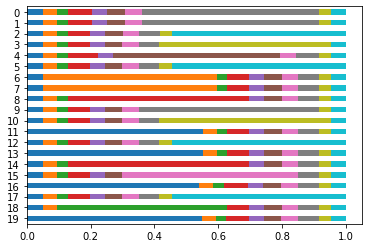

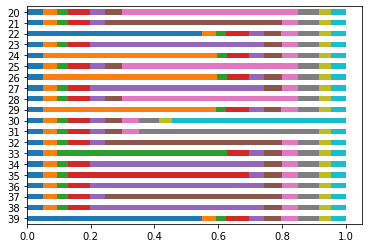

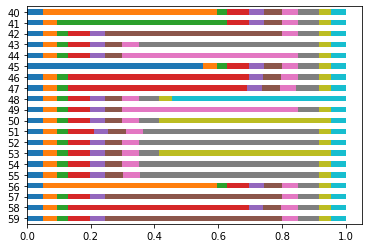

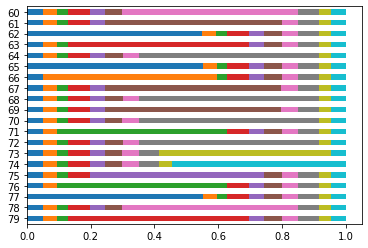

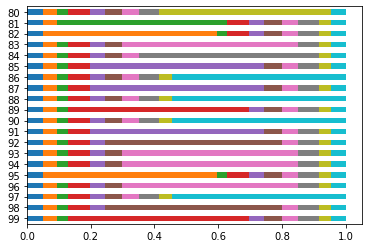

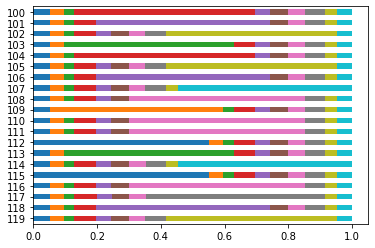

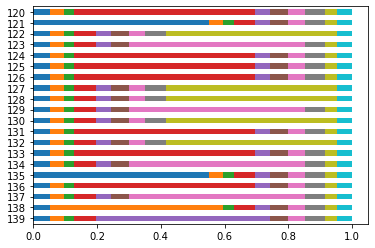

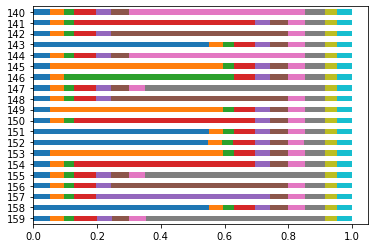

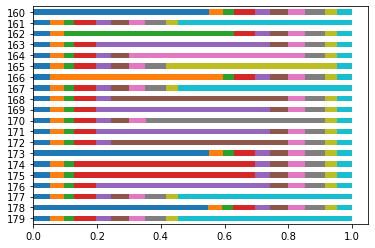

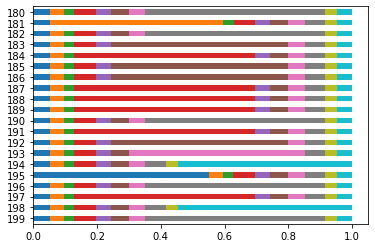

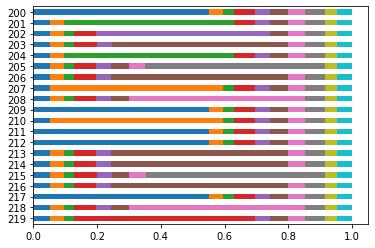

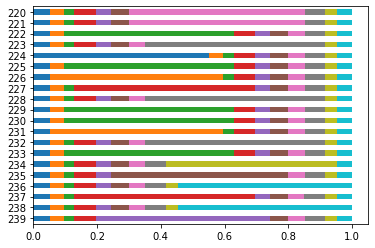

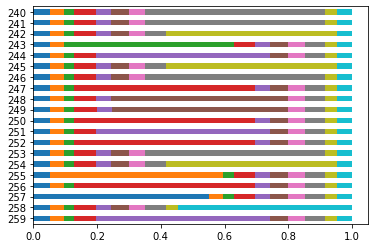

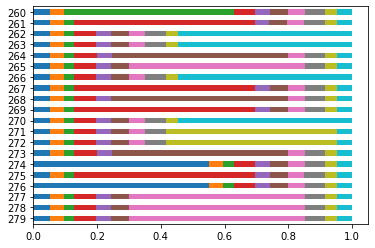

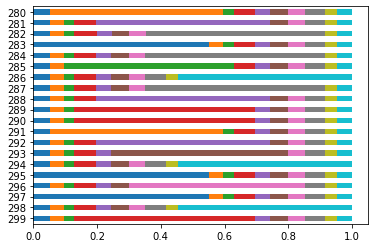

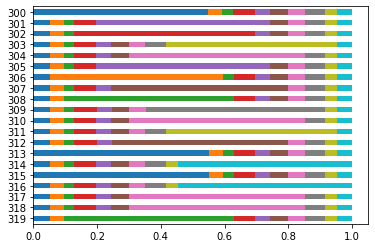

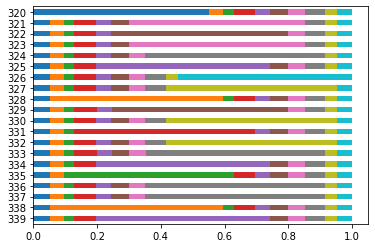

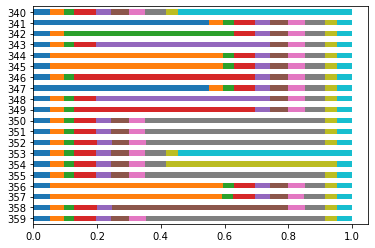

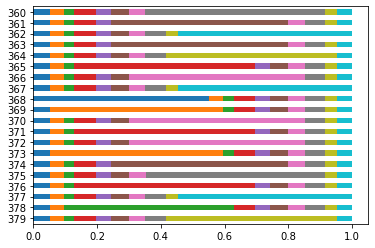

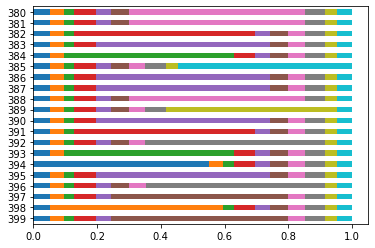

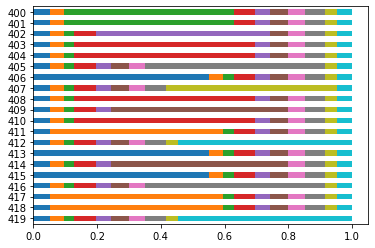

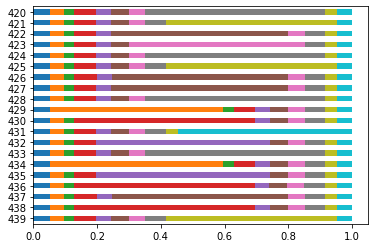

In [19]:
import pandas as pd

gamma = pd.read_csv('gamma.csv', index_col=0)
print('Group memberships by node:')
for i in range(0, 440, 20):
    gamma[i:i+20].sort_index(ascending=False).plot.barh(stacked=True, legend=False)

I tested the model on the members of the first 10 groups. It seems that the model assigns always assigns only one group
for each node, which makes sense, as there are always countless emails that are by default sent within departments.

## 4.

### Mahdi Shafiei & Hugh Chipman 2010. Mixed-Membership Stochastic Block-Models for Transactional Networks

The aim of the paper is to model transactional graph data with relationships between several nodes.
The inference algorithm uses variational approximation to estimate latent variables which describe connection
probabilities between individual nodes, between clusters, and membership in clusters.
The model works well for modeling soft cluster data, such as social media interactions.
